In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt


from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from IPython.display import display

from sklearn.ensemble import StackingClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [137]:
# Sourced from the UCI website
from ucimlrepo import fetch_ucirepo 

spambase = fetch_ucirepo(id=94) 
  
full_X = spambase.data.features
full_y = spambase.data.targets 

full = full_X.join(full_y)
train, test = train_test_split(full, test_size=0.20, stratify=full['Class'], random_state=123)

y = train.pop('Class').reset_index(drop=True)
X = train.reset_index(drop=True)

test_y = test.pop('Class').reset_index(drop=True)
test_X = test.reset_index(drop=True)

In [4]:
# Log transform capital columns
def capital_log_transform(X):
    X = X.copy()
    rest_cols = X.filter(like='capital').columns
    X[rest_cols] = np.log(X[rest_cols])
    return X
CapitalLogTransformer = FunctionTransformer(capital_log_transform)

# Convert percentages to [0,1] range
def freq_percent_transform(X):
    X = X.copy()
    freq_cols = X.filter(like='freq').columns
    X[freq_cols] /= 100
    return X
FreqPercentTransformer = FunctionTransformer(capital_log_transform)

# Sqrt transform freq cols
def freq_sqrt_transform(X):
    X = X.copy()
    freq_cols = X.filter(like='freq').columns
    X[freq_cols] = np.sqrt(X[freq_cols])
    return X
FreqSqrtTransformer = FunctionTransformer(freq_sqrt_transform)

# log transform freq cols
def freq_log_transform(X):
    X = X.copy()
    freq_cols = X.filter(like='freq').columns
    X[freq_cols] = np.log(X[freq_cols]+0.001)
    return X
FreqLogTransformer = FunctionTransformer(freq_log_transform)

# Mark zero freq values
def freq_zero_transform(X):
    X = X.copy()
    freq_cols = X.filter(like='freq').columns
    # Name them zero_i so later transform steps dont mess it up
    zero_mark_cols =  'zero_i' + pd.Index(np.arange(len(freq_cols))).astype(str)
    X[zero_mark_cols] = X[freq_cols] > 0
    return X
FreqZeroTransformer = FunctionTransformer(freq_zero_transform)

In [5]:
def wrap_model(scaler=StandardScaler, transformers=[], poly=False):
    def inner(model):
        return make_pipeline(*transformers,
                             *([scaler()] if scaler else []), 
                             *([PolynomialFeatures(2, interaction_only=True)] if poly else []), 
                             model)
    return inner

default = wrap_model()

def test_model(model, X, y, preprocess=True, metric='accuracy', splits=5, in_transformer=StandardScaler):
    # If no preprocessing, just use model
    pipeline = model
    if preprocess:
        pipeline = wrap_model(model, in_transformer)
        
    kf = KFold(n_splits=splits, shuffle=True, random_state=0)
    cv_results = cross_val_score(
        pipeline,
        X,
        y,
        cv=kf,
        scoring=metric,
        n_jobs=-1)
    
    return cv_results

def test_models(models, X, y, metric='accuracy', splits=5, in_transformer=StandardScaler, preprocess=True):
    for model in models:
        result = test_model(model, X, y, metric=metric, in_transformer=in_transformer, preprocess=preprocess).mean()
        print(f'{model}: {result}')

In [166]:
outliers = pd.Series(0, index=np.arange(len(X)))
for col in X.columns:
    q = X[X[col]>0][col].quantile(0.99)
    outliers |= X[col] > q

X2 = X[~outliers].copy().reset_index(drop=True)
y2 = y[~outliers].copy().reset_index(drop=True)

outliers.sum()

362

In [167]:
neg_low_corr_cols = [
    'word_freq_parts', 'word_freq_direct', 'word_freq_table', 'char_freq_;', 'char_freq_('
]
pos_low_corr_cols = [ 'word_freq_3d' ]

pca = wrap_model(transformers=[CapitalLogTransformer, FreqSqrtTransformer])(PCA(n_components=2)).fit(X2[neg_low_corr_cols])
pca_out = pd.DataFrame(pca.transform(X2[neg_low_corr_cols]))

X_pca = X2.copy()
X_pca = X_pca.drop(neg_low_corr_cols, axis=1)
X_pca = X_pca.drop(pos_low_corr_cols, axis=1)
X_pca['pca0'] = pca_out[0]
X_pca['pca1'] = pca_out[1]

In [15]:
best_transformers = [CapitalLogTransformer, FreqZeroTransformer, FreqSqrtTransformer]

## Stacking

In [224]:
# Found via GridSearch
model = wrap_model(transformers=best_transformers)(
    StackingClassifier(estimators=[(f'l{i}', val) for i,val in enumerate([
        LogisticRegression(C=0.01),
        XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='aucpr', 
                      eta=0.1, gamma=2, max_depth=15, min_child_weight=1, subsample=0.6),
        ExtraTreesClassifier(max_depth=15, max_features='log2', min_samples_split=5,
                             n_estimators=400, random_state=42),
        SVC(C=10, gamma=0.01, kernel='poly'),
        HistGradientBoostingClassifier(l2_regularization=1, learning_rate=0.3, 
                                       max_depth=5, min_samples_leaf=10, random_state=42)
    ])], n_jobs=-1)
)

### Scores

In [225]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(model, X_pca, y2, scoring=scoring,
                         cv=4, return_train_score=True)
pd.DataFrame(pd.DataFrame(scores).mean()).T

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,4.003783,0.113121,0.959314,0.991059,0.956225,0.996561,0.937554,0.980225,0.94675,0.988322


### ROC

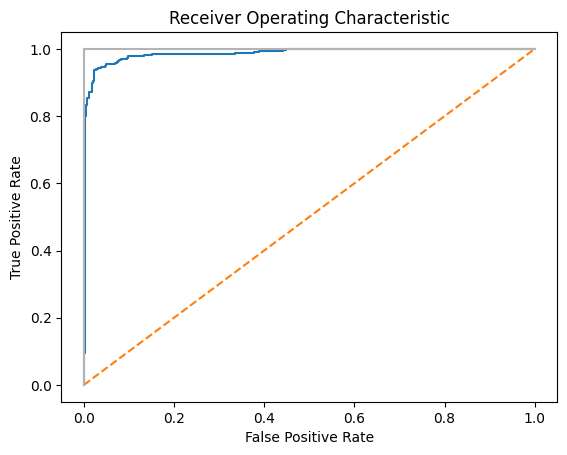

0.9872330341538553

In [226]:
model.fit(X, y)

prob_y = model.predict_proba(test_X)[:,1]

fpr, tpr, threshold = roc_curve(
    test_y,
    prob_y
)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c="0.7"), plt.plot([1, 1] , c="0.7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

roc_auc_score(test_y, prob_y)

In [227]:
res = pd.DataFrame({
    'thresh': threshold, 
    'tpr': tpr, 
    'fpr': fpr
})
res['thresh'] = round(res['thresh']*100,5)
res

,thresh,tpr,fpr
0,inf,0.000000,0.000000
1,99.99918,0.002755,0.000000
2,99.91535,0.096419,0.000000
3,99.91052,0.096419,0.001792
4,99.65504,0.162534,0.001792
5,99.65111,0.168044,0.001792
6,98.59821,0.396694,0.001792
7,98.57140,0.402204,0.001792
8,98.36445,0.443526,0.001792
9,98.36291,0.449036,0.001792


In [228]:
predict_y = model.predict(test_X)
conf_mat = confusion_matrix(test_y, predict_y)
conf_mat

array([[544,  14],
       [ 23, 340]])

In [237]:
predict_y = (model.predict_proba(test_X)[:,1] >= 0.82)
conf_mat = confusion_matrix(test_y, predict_y)
conf_mat

array([[551,   7],
       [ 47, 316]])

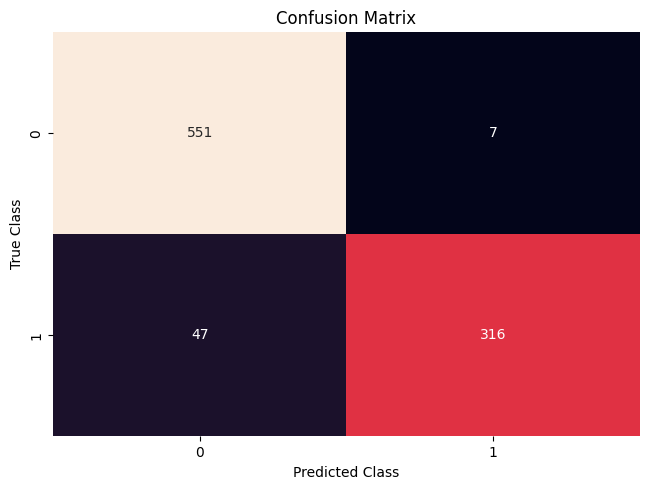

In [238]:
df = pd.DataFrame(conf_mat)
sns.heatmap(df, annot=True, cbar=None, fmt='d')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

## ExtraTrees

In [239]:
model = wrap_model(transformers=[FreqSqrtTransformer, CapitalLogTransformer])(
    ExtraTreesClassifier(max_depth=15, max_features='log2', min_samples_split=5,
                         n_estimators=400, random_state=42),
)

In [240]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(model, X_pca, y2, scoring=scoring,
                         cv=4, return_train_score=True)
pd.DataFrame(pd.DataFrame(scores).mean()).T

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.549778,0.047663,0.948163,0.975588,0.962521,0.991549,0.900862,0.944836,0.930596,0.967618


### ROC

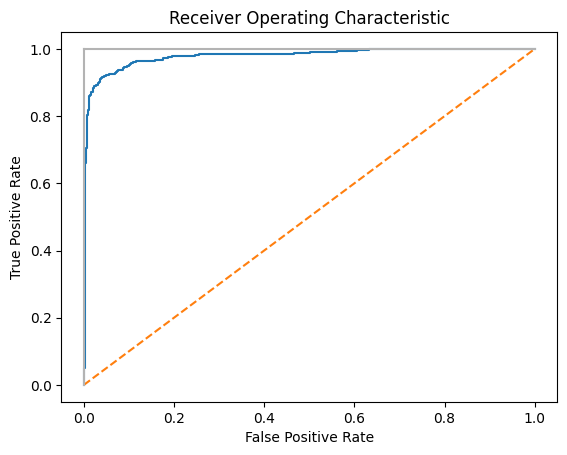

0.9791166799964454

In [241]:
model.fit(X, y)

prob_y = model.predict_proba(test_X)[:,1]

fpr, tpr, threshold = roc_curve(
    test_y,
    prob_y
)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c="0.7"), plt.plot([1, 1] , c="0.7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

roc_auc_score(test_y, prob_y)

In [242]:
res = pd.DataFrame({
    'thresh': threshold, 
    'tpr': tpr, 
    'fpr': fpr
})
res['thresh'] = round(res['thresh']*100,5)
res

,thresh,tpr,fpr
0,inf,0.000000,0.000000
1,99.80308,0.002755,0.000000
2,99.69166,0.008264,0.000000
3,99.67716,0.013774,0.000000
4,99.66488,0.016529,0.000000
5,99.57766,0.022039,0.000000
6,99.16013,0.049587,0.000000
7,99.05404,0.049587,0.001792
8,98.92813,0.057851,0.001792
9,98.83153,0.063361,0.001792


In [246]:
predict_y = model.predict(test_X)
conf_mat = confusion_matrix(test_y, predict_y)
conf_mat

array([[547,  11],
       [ 44, 319]])

In [248]:
predict_y = (model.predict_proba(test_X)[:,1] >= 0.56)
conf_mat = confusion_matrix(test_y, predict_y)
conf_mat

array([[551,   7],
       [ 51, 312]])

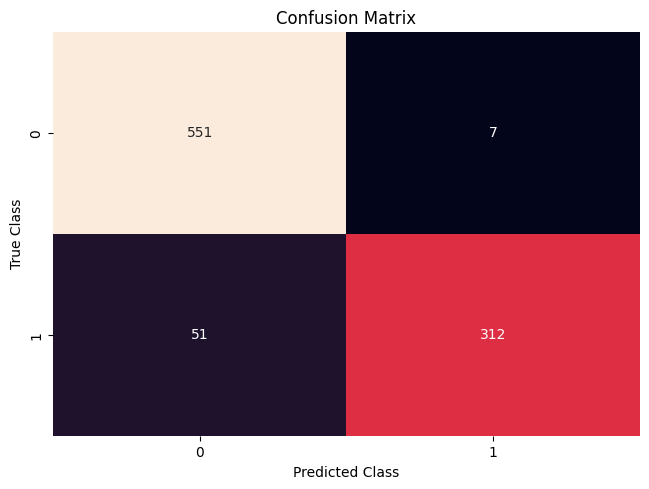

In [249]:
df = pd.DataFrame(conf_mat)
sns.heatmap(df, annot=True, cbar=None, fmt='d')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

## SVC

In [199]:
model = wrap_model(transformers=best_transformers)(
    SVC(C=10, gamma=0.01, kernel='poly', probability=True),
)

### Scores

In [200]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(model, X_pca, y2, scoring=scoring,
                         cv=5, return_train_score=True)
pd.DataFrame(pd.DataFrame(scores).mean()).T

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.51702,0.03376,0.956302,0.988246,0.9603,0.995026,0.925064,0.974434,0.942332,0.984618


### ROC

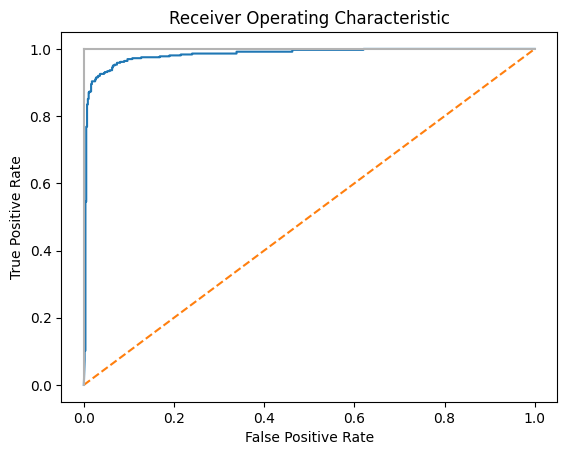

0.9830390908103518

In [201]:
model.fit(X, y)

prob_y = model.predict_proba(test_X)[:,1]

fpr, tpr, threshold = roc_curve(
    test_y,
    prob_y
)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c="0.7"), plt.plot([1, 1] , c="0.7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

roc_auc_score(test_y, prob_y)

In [202]:
res = pd.DataFrame({
    'thresh': threshold, 
    'tpr': tpr, 
    'fpr': fpr
})
res['thresh'] = round(res['thresh']*100,5)
res

,thresh,tpr,fpr
0,inf,0.000000,0.000000
1,100.00000,0.074380,0.001792
2,100.00000,0.101928,0.001792
3,100.00000,0.101928,0.003584
4,99.99999,0.170799,0.003584
5,99.99999,0.176309,0.003584
6,98.64849,0.421488,0.003584
7,98.61007,0.426997,0.003584
8,98.27401,0.443526,0.003584
9,98.22263,0.454545,0.003584


In [203]:
predict_y = model.predict(test_X)
conf_mat = confusion_matrix(test_y, predict_y)
conf_mat

array([[544,  14],
       [ 34, 329]])

In [215]:
predict_y = (model.predict_proba(test_X)[:,1] >= 0.74)
conf_mat = confusion_matrix(test_y, predict_y)
conf_mat

array([[552,   6],
       [ 47, 316]])

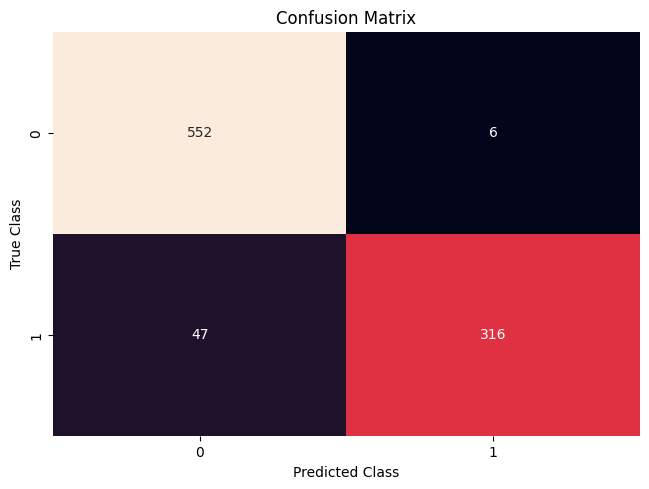

In [216]:
df = pd.DataFrame(conf_mat)
sns.heatmap(df, annot=True, cbar=None, fmt='d')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [128]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(model, X, y, scoring=scoring,
                         cv=5, return_train_score=True)
pd.DataFrame(pd.DataFrame(scores).mean()).T

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,6.278863,0.413824,0.953679,0.999555,0.954097,1.0,0.928511,0.998883,0.941093,0.999441


In [ ]:
# In this case we care about precision the most out of the three
# Aka we want to lower the amount of false positives as much as possible
# without sacrificing the score too much

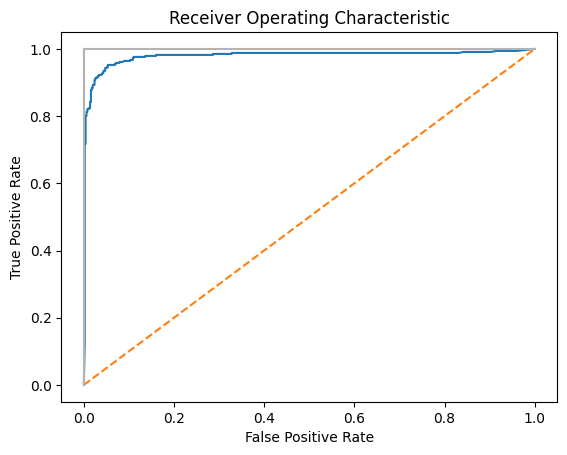

0.9789843308865049

In [129]:
model.fit(X, y)

prob_y = model.predict_proba(test_X)[:,1]

fpr, tpr, threshold = roc_curve(
    test_y,
    prob_y
)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c="0.7"), plt.plot([1, 1] , c="0.7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

roc_auc_score(test_y, prob_y)

In [130]:
pd.DataFrame({
    'thresh': threshold, 
    'tpr': tpr, 
    'fpr': fpr
})

,thresh,tpr,fpr
0,inf,0.000000,0.000000
1,1.000000,0.125000,0.001976
2,0.999714,0.175595,0.001976
3,0.999143,0.205357,0.001976
4,0.998857,0.217262,0.001976
5,0.998571,0.223214,0.001976
6,0.998286,0.235119,0.001976
7,0.998000,0.250000,0.001976
8,0.997714,0.252976,0.001976
9,0.997429,0.258929,0.001976


In [131]:
predict_y = model.predict(test_X)
conf_mat = confusion_matrix(test_y, predict_y)
conf_mat

array([[491,  15],
       [ 28, 308]])

In [136]:
predict_y = (model.predict_proba(test_X)[:,1] >= 0.68)
conf_mat = confusion_matrix(test_y, predict_y)
conf_mat

array([[500,   6],
       [ 59, 277]])

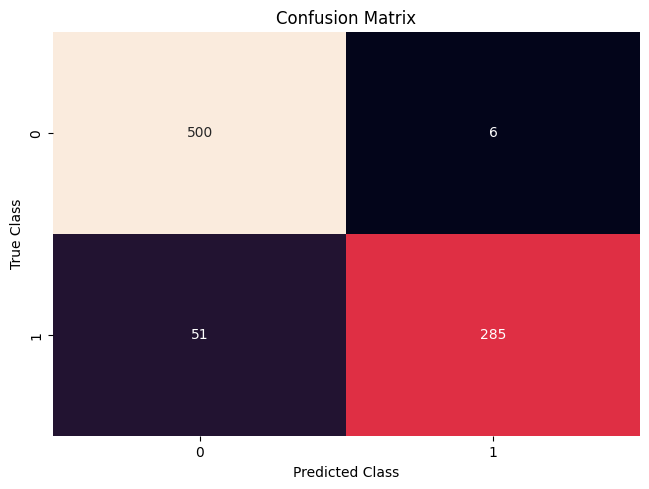

In [125]:
df = pd.DataFrame(conf_mat)
sns.heatmap(df, annot=True, cbar=None, fmt='d')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()